## Desafío 3 - DH - ML Clasificación

<a id="tabla_contenidos"></a> 
### Tabla de Contenidos

#### <a href='#section_proposito'>0. Propósito de esta Notebook</a>
- ##### <a href='#section_motivacion'>0.1 Motivación</a>
- ##### <a href='#section_dataset_info'>0.2 Detalles del Dataset</a>
- ##### <a href='#section_antecedentes'>0.3 Estado del Arte</a>

#### <a href='#section_preparacion'>1. Estudio del Dataset</a>
- ##### <a href='#section_importacion'>1.1 Importación</a>
- ##### <a href='#section_analisis'>1.2 Análisis Exploratorio</a>
- ##### <a href='#section_split'>1.3 Selección de Target</a>

#### <a href='#section_algoritmos'>2. Algoritmos y predicción</a>
- ##### <a href='#acon_dataset'>2.1 Acondicionamiento del Dataset</a>
- ##### <a href='#knn'>2.2 K Nearest Neighbors (KNN)</a>
- ##### <a href='#reg_log'>2.3 Regresión Logística</a>
- ##### <a href='#resultados'>2.4 Comparación de Resultados</a>

#### <a href='#section_consolidacion'>3. Consolidación</a>
- ##### <a href='#pipe'>3.1 Pipelines</a>
- ##### <a href='#conclusion'>3.2 Conclusión</a>

<hr>

### <a id='section_proposito'>0. Propósito de esta Notebook</a>

#### <a id="section_motivacion">0.1 Motivación</a> 

<hr>

<a id='section_preparacion'></a> 
## 1. Preparación del Dataset

### <a id="section_importacion">1.1 Importación de datos</a> 

### Importación de datos de población y resultados de encuesta
Los datos de población nos permitirán realizar una exploración geográfica de la ubicación de los encuestados

In [1]:
# librerías
import numpy as np
import pandas as pd
import unicodedata

In [2]:
resultados_del_test = pd.read_csv("data/resultados-del-test.csv", delimiter = ",")

In [3]:
poblacion_por_barrio = pd.read_csv("data/caba_pob_barrios_2010.csv")

#### Unifico en un dataset
Elimino tildes en los nombres de los barrios de cada dataset y agrego población por barrio al resultado de las encuestas

In [4]:
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [5]:
poblacion_por_barrio.BARRIO = poblacion_por_barrio.BARRIO.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [6]:
resultados_del_test.barrio = resultados_del_test.barrio.apply(elimina_tildes).apply(lambda barrio: barrio.capitalize())

In [7]:
poblacion_por_barrio.columns = ['barrio', 'poblacion']

In [8]:
poblacion_por_barrio = poblacion_por_barrio.set_index('barrio')

In [9]:
def obtener_poblacion_por_barrio(barrio):
    return poblacion_por_barrio.loc[barrio].poblacion

In [10]:
# la imputación unifica denominaciónes y rellena 'Otro' con un barrio aleatorio

def imputar_barrio(barrio):
    barrios = poblacion_por_barrio.index.tolist()
    if barrio == "La boca": return "Boca"
    if barrio == "Montserrat": return "Monserrat"
    if barrio == "Villa general mitre": return "Villa gral. mitre"
    if barrio == "La paternal": return "Paternal"
    if barrio == "Otro": return np.random.choice(barrios)
    return barrio

In [11]:
resultados_del_test["barrio_completo"] = resultados_del_test.barrio.apply(imputar_barrio)

In [12]:
resultados_del_test["poblacion_por_barrio"] = resultados_del_test.barrio_completo.apply(obtener_poblacion_por_barrio)

#### Exporto y resguardo el dataset unificado

In [13]:
resultados_del_test.to_csv("data/dataset_joined.csv")

## <a id="section_analisis">1.2 Análisis Exploratorio</a> 

Importo el dataset unificado

In [14]:
dataset = pd.read_csv("data/dataset_joined.csv", delimiter = ",",  index_col = "Unnamed: 0")
dataset.head(3)

,fecha,hora,edad,genero,barrio,pregunta_1,pregunta_2,pregunta_3,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,pregunta_11,pregunta_12,pregunta_13,barrio_completo,poblacion_por_barrio
0,2019-06-14,09:09:00,27,Mujer,Constitucion,A,A,A,B,A,B,C,C,B,C,B,C,C,Constitucion,44107
1,2019-06-13,23:20:00,17,Mujer,Otro,A,B,B,B,B,C,C,B,B,C,B,C,C,Villa pueyrredon,39654
2,2019-06-13,16:33:00,15,Mujer,Recoleta,B,B,C,B,C,B,B,A,A,A,A,A,A,Recoleta,157932


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5676 entries, 0 to 5675
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fecha                 5676 non-null   object
 1   hora                  5676 non-null   object
 2   edad                  5676 non-null   int64 
 3   genero                5676 non-null   object
 4   barrio                5676 non-null   object
 5   pregunta_1            5676 non-null   object
 6   pregunta_2            5676 non-null   object
 7   pregunta_3            5676 non-null   object
 8   pregunta_4            5676 non-null   object
 9   pregunta_5            5676 non-null   object
 10  pregunta_6            5676 non-null   object
 11  pregunta_7            5676 non-null   object
 12  pregunta_8            5676 non-null   object
 13  pregunta_9            5676 non-null   object
 14  pregunta_10           5676 non-null   object
 15  pregunta_11           5676 non-null   

### Visualizamos los nulos

In [16]:
### librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [17]:
dataset_columnas = dataset[["fecha",'edad', 'genero', 'barrio','barrio_completo','poblacion_por_barrio']]

In [18]:
from IPython.display import Markdown, display

nulls_by_column = dataset_columnas.isnull().sum()
dataset_size = dataset.shape[0]

for column in nulls_by_column.index:
    column_nulls = nulls_by_column[column]
    null_percentage = 100 * column_nulls / dataset_size
    display(Markdown(f"* ```{column}``` tiene {column_nulls} nulos, lo cual representa el {null_percentage:.2f}%"))

* ```fecha``` tiene 0 nulos, lo cual representa el 0.00%

* ```edad``` tiene 0 nulos, lo cual representa el 0.00%

* ```genero``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio``` tiene 0 nulos, lo cual representa el 0.00%

* ```barrio_completo``` tiene 0 nulos, lo cual representa el 0.00%

* ```poblacion_por_barrio``` tiene 0 nulos, lo cual representa el 0.00%

### Barrio de los encuestados

In [19]:
# algunos de los barrios imputados en 'Otro'
dataset.loc[dataset.barrio == 'Otro','barrio_completo'].head(10)

1     Villa pueyrredon
8         Villa crespo
9              Palermo
10    Villa pueyrredon
16           Agronomia
18     Velez sarsfield
24        Monte castro
25       Villa soldati
26               Nunez
32           Balvanera
Name: barrio_completo, dtype: object

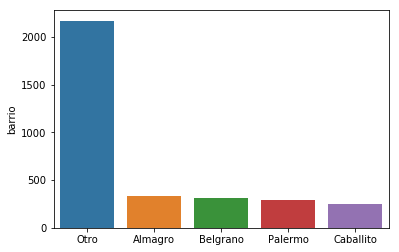

In [20]:
# barrios sin imputaciones
sns.barplot(x=dataset.barrio.value_counts().head(5).index, y=dataset.barrio.value_counts().head(5))

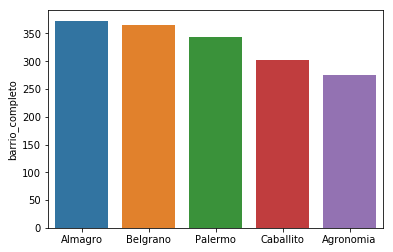

In [21]:
# barrios con imputaciones
sns.barplot(x=dataset.barrio_completo.value_counts().head(5).index, y=dataset.barrio_completo.value_counts().head(5))

#### Vemos los primeros quince barrios con más encuestados

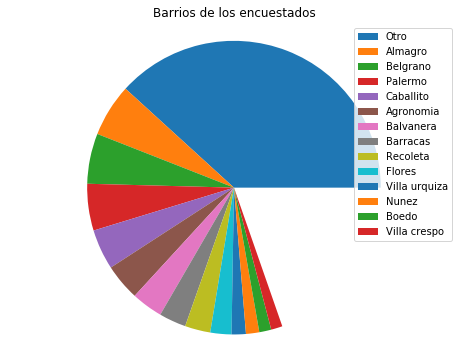

In [22]:
labels = dataset.barrio.value_counts(normalize=True).index[:14]
sizes = list(dataset.barrio.value_counts(normalize=True)[:14])

figura, axis = plt.subplots(figsize=(8,6))
axis.pie(sizes)
axis.axis('equal') 
axis.set_title('Barrios de los encuestados')
axis.legend(labels)

### Edades de los encuestados

#### Visualizamos las edades y sus outliers

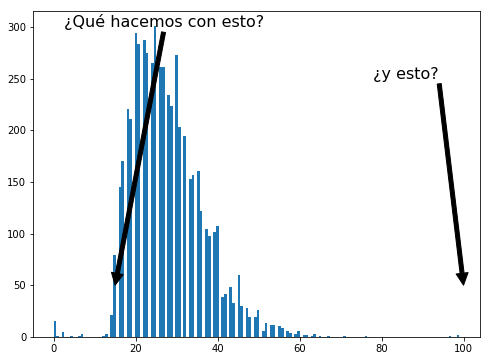

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(dataset.edad, bins=150);
plt.annotate('¿Qué hacemos con esto?', xy=(15, 50), xytext=(2.5, 300),arrowprops=dict(facecolor='black', shrink=15), fontsize=16)
plt.annotate('¿y esto?', xy=(100, 50), xytext=(78, 250), arrowprops=dict(facecolor='black', shrink=15), fontsize=16);
plt.show()

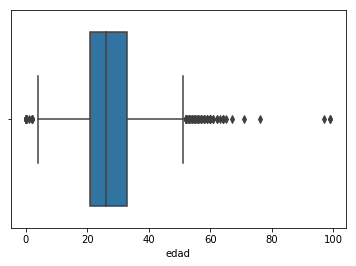

In [24]:
sns.boxplot(dataset.edad)

#### Quitamos los outliers<br>
Vemos cómo quedaria la distribución si usamos los rangos intercuartiles para quitar outliers.

In [25]:
dataset_edad = dataset["edad"]


El skew es 0.5893768101027447 cuando quitamos los outliers


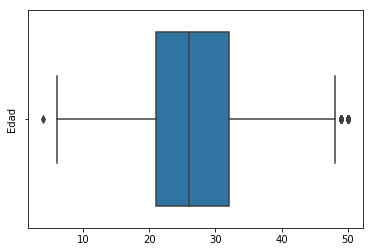

In [26]:
q1 = dataset_edad.quantile(0.25)
q2 = dataset_edad.quantile(0.5)
q3 = dataset_edad.quantile(0.75)

iqr = q3 - q1

up_threshold = q3 + 1.5 * iqr
low_threshold = q1 - 1.5* iqr

no_outliers_mask = (dataset_edad > low_threshold) & (dataset_edad < up_threshold)

ax = sns.boxplot(dataset_edad[no_outliers_mask], orient = 'h').set(
    xlabel='', 
    ylabel='Edad'
)
print(f"\nEl skew es {dataset_edad[no_outliers_mask].skew()} cuando quitamos los outliers")

In [27]:
n_without_outliers = dataset_edad[no_outliers_mask].shape[0]
n_including_outliers = dataset_edad.shape[0]

taken_percentage = 100 * n_without_outliers / n_including_outliers
print(f"""
Sin outliers hemos tomado un {taken_percentage:.2f}% de los datos que teníamos, considerando solamente {n_including_outliers - n_without_outliers} registros como outliers.""")


Sin outliers hemos tomado un 97.97% de los datos que teníamos, considerando solamente 115 registros como outliers.


### Género de encuestados

In [28]:
dataset["genero"].value_counts()

Mujer     4736
Hombre     912
Otro        28
Name: genero, dtype: int64

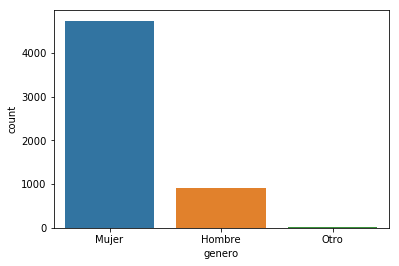

In [29]:
sns.countplot(x='genero', data=dataset)

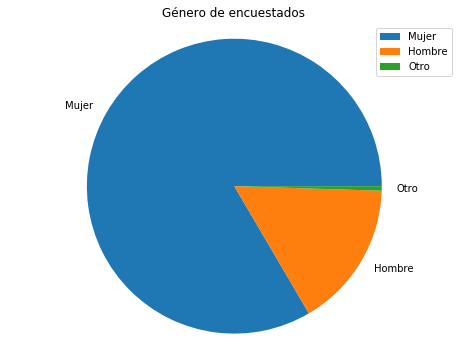

In [30]:
labels = dataset.genero.value_counts(normalize=True).index
sizes = list(dataset.genero.value_counts(normalize=True))

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(sizes, labels=labels)
ax1.axis('equal') 
ax1.set_title('Género de encuestados')
ax1.legend()

### Respuestas

In [31]:
preguntas = ['1. ¿Cuando no están juntos/as, ¿tu pareja te controla preguntándote con quién estás,\n dónde y qué estás haciendo mensajeándote por celular?', 
 '2. ¿Revisa los mensajes de tu celular o te pidió la contraseña de tu correo electrónico,\n Facebook o Instagram como “prueba de confianza”?',
 '3. ¿Te acusa de haber sido infiel o coquetear con otras/os?',
 '4. ¿Sentís que están permanentemente en tensión y que, hagas lo que hagas, se irrita\n o te culpabiliza de sus cambios de humor?',
 '5. ¿Le molesta que hagas actividades de manera independiente, como estudiar, trabajar,\n visitar amigos/as, ir al gimnasio o elegir quedarte solo/a en tu casa?',
 '6. ¿Sentís que te alejaste o perdiste contacto con amigos/as o familiares desde que estás en pareja?',
 '7. ¿Te dice cómo tenés que vestirte o cómo debe ser tu apariencia?',
 '8. ¿Menosprecia en público o en privado tus opiniones?',
 '9. ¿Te dice que todo lo que hacés está mal o que no servís para nada?',
 '10. ¿Te amenaza con lastimarse/te si no lo/la obedecés o si querés terminar la relación?',
 '11. Después de un episodio violento, ¿se muestra cariñoso/a o atento/a\n y promete que nunca más lo hará y todo cambiará?',
 '12. ¿Indaga o cuestiona tus noviazgos anteriores?',
 '13. ¿Te sentís presionado/a a realizar determinadas prácticas sexuales por temor a que te deje?']

In [32]:
respuestas = ['A = Siempre', 'B = "A veces"', 'C = Nunca']

In [33]:
# recorto el dataset para poder reescribir las respuestas y plotear los resultados

data = dataset[['genero'] + list(dataset.columns[6:18])]

In [34]:
for columna in data.drop('genero',axis=1).columns:
    data.loc[:,columna] = dataset.loc[:,columna].replace('A','Siempre').replace('B','A veces').replace('C','Nunca')

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### Respuestas según género

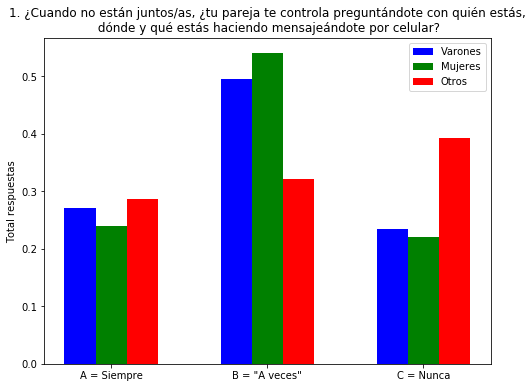

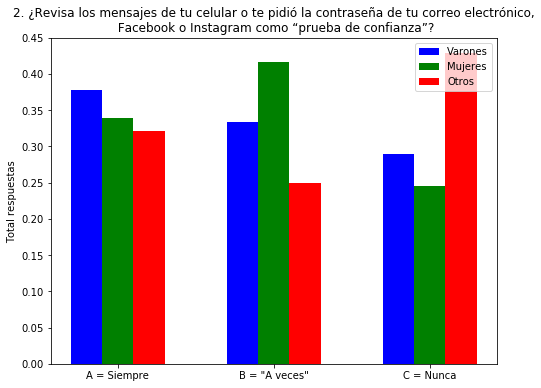

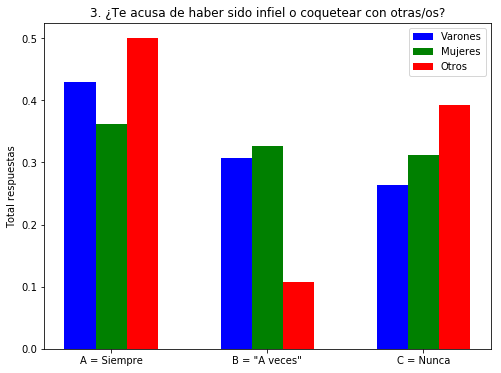

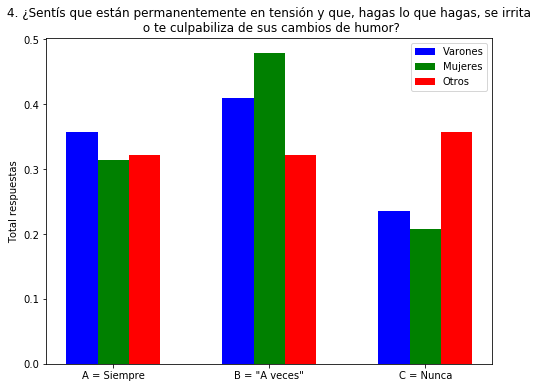

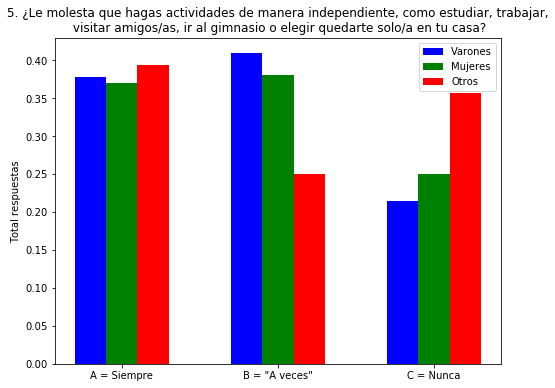

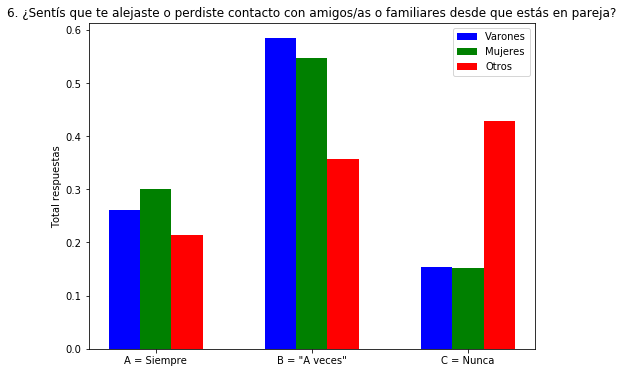

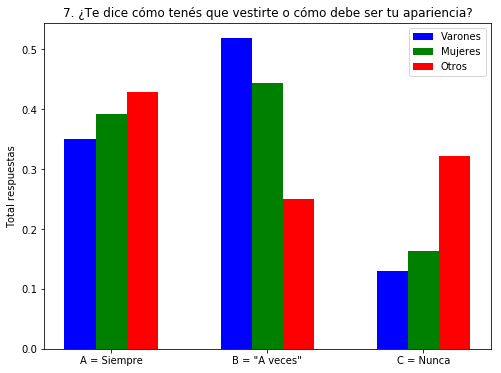

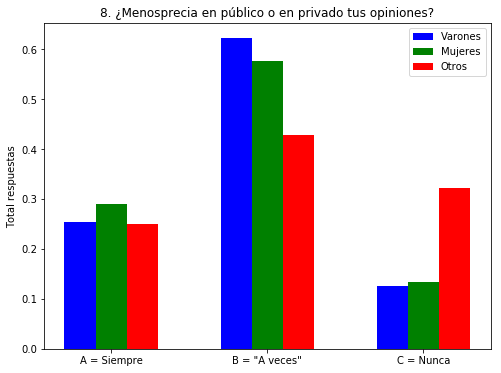

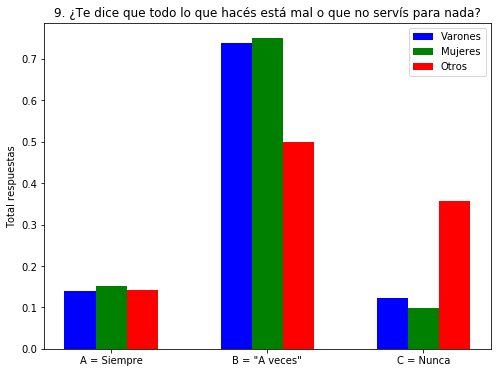

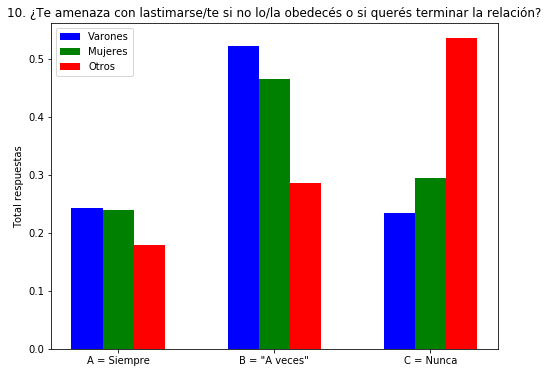

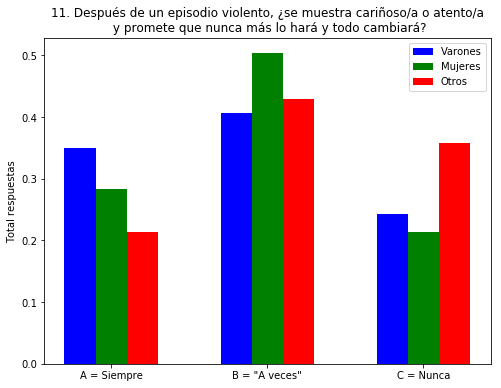

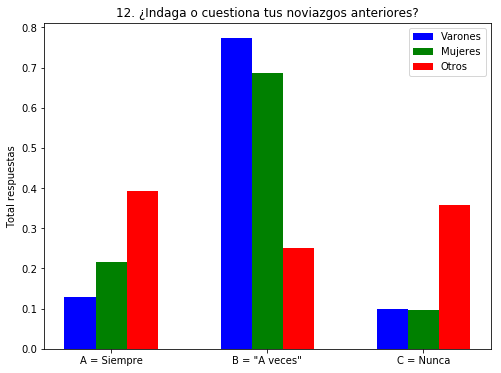

In [35]:
for num,columna in enumerate(data.drop('genero',axis=1).columns):
    respuesta = set(np.array(list(data.groupby(columna).genero.value_counts().index))[:,0])
    # respuesta por hombres
    n_varones = (data.genero == 'Hombre').sum()
    n_mujeres = (data.genero == 'Mujer').sum()
    n_otros = (data.genero == 'Otro').sum()
    varones = list(data.groupby(columna).genero.value_counts())[1::3] / n_varones
    # respusta por mujeres
    mujeres = list(data.groupby(columna).genero.value_counts())[::3] / n_mujeres 
    # respusta por otros
    otros = list(data.groupby(columna).genero.value_counts())[2::3] / n_otros

    x = np.arange(len(respuesta))
    width = 0.2

    fig, ax = plt.subplots(figsize=(8,6))
    barra1 = ax.bar(x, varones, width, label='Varones', color='blue')
    barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres', color='green')
    barra3 = ax.bar(x+0.4, otros, width, label='Otros', color='red')

    ax.set_ylabel('Total respuestas')
    ax.set_title(preguntas[num])
    ax.set_xticks(x+0.2)
    ax.set_xticklabels(respuestas)
    ax.legend()

### <a id="section_split">1.3 Selección de Target</a> 

Seleccionamos el target (columna: 'df.pregunta_13') y lo transformamos en dicotómico. Descartamos la respuesta "intermedia", considerado "A veces" como "Siempre".

In [36]:
data.pregunta_13.value_counts()

Nunca      3963
A veces    1155
Siempre     558
Name: pregunta_13, dtype: int64

In [37]:
# agrego el target al dataframe
dataset['target'] = dataset.pregunta_13 != 'C'

In [38]:
# agrego el target al dataframe al dataframe destinado al ploteo para ver distribución de las respuestas
data['target']  = dataset.target.apply(lambda x: 'Nunca' if x is False else 'Siempre')

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
data.target.value_counts()

Nunca      3963
Siempre    1713
Name: target, dtype: int64

#### Observamos la distribución de las respuestas del target (según género)

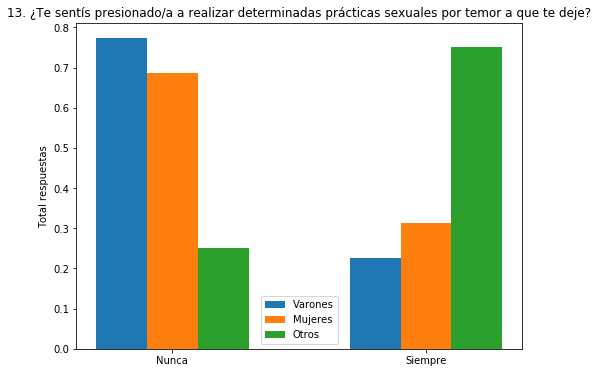

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

respuesta = list(data.target.value_counts().index)

n_varones = (data.genero == 'Hombre').sum()
n_mujeres = (data.genero == 'Mujer').sum()
n_otros = (data.genero == 'Otro').sum()

varones = list(data.groupby('target').genero.value_counts())[1::3] / n_varones
mujeres = list(data.groupby('target').genero.value_counts())[::3] / n_mujeres 
otros = list(data.groupby('target').genero.value_counts())[2::3] / n_otros

x = np.arange(len(respuesta))
width = 0.2

barra1 = ax.bar(x, varones, width, label='Varones')
barra2 = ax.bar(x+0.2, mujeres, width, label='Mujeres')
barra3 = ax.bar(x+0.4, otros, width, label='Otros')

ax.set_ylabel('Total respuestas')
ax.set_title(preguntas[12])
ax.set_xticks(x + 0.2)
ax.set_xticklabels(respuesta)
ax.legend()

Observamos que los casos negativos son mayoría, salvo entre quienes declararon "Otros" en la pregunta sobre el género

<hr>

## <a id='section_algoritmos'>2. Algoritmos y predicción</a>

### <a id='acon_dataset'>2.1 Acondicionamiento del Dataset</a>

#### Distinción de variables categoricas y continuas

In [41]:
categorical_columns = ['genero', 'barrio_completo'] + [col for col in dataset.columns if 'pregunta_13' not in col and 'pregunta' in col]

In [42]:
numerical_columns = ['edad', 'poblacion_por_barrio']

#### Creacion de dummies

In [43]:
categorical_features_df = pd.get_dummies(dataset.loc[:, categorical_columns])

In [44]:
# agregamos los dummmies al datset

dataset = pd.concat([dataset, categorical_features_df], axis = 1)

In [45]:
# lista de varibales categóricas
categorical_features = categorical_features_df.columns.tolist()

#### train y test: divido utilizando los indices solamente

In [46]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(dataset.index, stratify = dataset.target, random_state = 42)

#### Escalado de variables continuas

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# entreno el modelo de estandarización
scaler.fit(dataset.loc[train_index, numerical_columns])

# transformo cada set de datos de las columnas con variables numéricas
train_numerical_scaled = scaler.transform(dataset.loc[train_index, numerical_columns])
test_numerical_scaled = scaler.transform(dataset.loc[test_index, numerical_columns])

In [48]:
# lista de variables numéricas
numerical_features = [f"{col}_scaled" for col in numerical_columns]

In [49]:
train_numerical_df = pd.DataFrame(train_numerical_scaled, index = train_index, columns = numerical_features)
test_numerical_df = pd.DataFrame(test_numerical_scaled, index = test_index, columns = numerical_features)

numerical_features_df = train_numerical_df.append(test_numerical_df)

#### Agrego features numéricas escaladas al dataset

In [50]:
dataset = pd.concat([dataset, numerical_features_df], axis = 1)

#### Generacion de train/test datasets con los features transformados y estandarizados

In [51]:
# los features equivalen a las variables categóricas dummies y a las numéricas estandarizadas
feature_cols = categorical_features + numerical_features

In [52]:
dataset_to_use = dataset.loc[:, feature_cols + ['target']]

In [53]:
train = dataset_to_use.loc[train_index]
test = dataset_to_use.loc[test_index]

In [54]:
X_train = train.drop('target', axis=1)
y_train = train.target

In [55]:
X_test = test.drop('target', axis=1)
y_test = test.target

#### Guardo train y test en formato csv para compartir

In [56]:
train.to_csv("data/train.csv")
test.to_csv("data/test.csv")

### <a id='knn'>2.1 K Nearest Neighbors (KNN)</a>

#### KNN - Ajustando el modelo
Buscando el mejor hiperparámetro

In [57]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=12)

In [59]:
scores = []

for i in range(1,10):
    modelo =  KNeighborsClassifier(n_neighbors=i)
    cvs = cross_val_score(modelo, X_train, y_train ,cv=kf)
    scores.append({'vecinos':i,
                  'media':np.mean(cvs),
                  'desvio':np.std(cvs)})

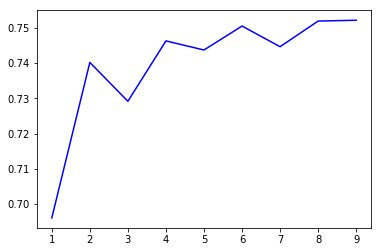

In [60]:
scores = pd.DataFrame(scores)
plt.plot(range(1,10), scores.media, color='b')

#### KNN - Hiperparámetro óptimo

In [61]:
vecinos = int(scores.loc[scores.media == scores.media.max(),'vecinos'])
scores.loc[scores.media == scores.media.max(),:]

,vecinos,media,desvio
8,9,0.752176,0.013494


#### KNN - Entreno el modelo

In [62]:
knn = KNeighborsClassifier(n_neighbors=vecinos)

In [63]:
knn.fit(X_train, y_train);

#### KNN - Distribución de resultados y umbral en Train

In [64]:
# probabilidades de etiqueta 0 o 'nunca'
nunca_knn = knn.predict_proba(X_train[y_train == 0])

In [65]:
# probabilidades de etiqueta 1 o 'siempre'
siempre_knn = knn.predict_proba(X_train[y_train == 1])

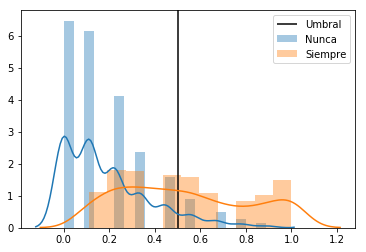

In [66]:
# ploteo la probabilidad de la aparición de la etiqueta
sns.distplot(nunca_knn[:,1])
sns.distplot(siempre_knn[:,1])
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Nunca', 'Siempre'])

#### KNN - Ajustamos el umbral
El propósito es reducir los casos violentos catalogados por el modelo como no violentos.

In [67]:
umbral = 0.3

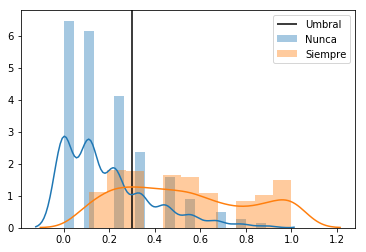

In [68]:
# muevo el umbral
sns.distplot(nunca_knn[:,1])
sns.distplot(siempre_knn[:,1])
ylim = plt.ylim()
plt.vlines(umbral, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Nunca', 'Siempre'])

In [69]:
# nos quedamos con un array booleanos que indica valores por encima del umbral (casos potencialmente violentos)
y_pred_knn_ajustado = knn.predict_proba(X_train)[:,1] > umbral

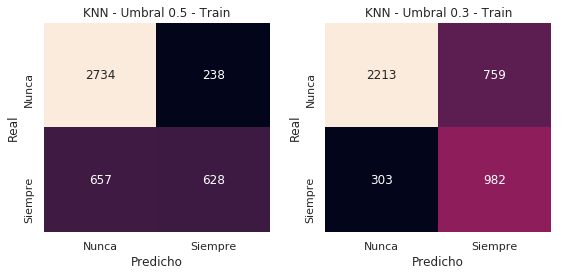

In [70]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_train, knn.predict(X_train)), cbar=False, annot=True, fmt='.0f',ax=axes[0])
sns.heatmap(confusion_matrix(y_train, y_pred_knn_ajustado), cbar=False, annot=True, fmt='.0f',ax=axes[1])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('KNN - Umbral 0.5 - Train')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('KNN - Umbral 0.3 - Train')

plt.tight_layout()

Aumentan los True Positives (los casos violentos catalogados como tal), al costo de aumentar los False Positives (los casos no violentos catalogados como violentos).

#### KNN - Prediciendo sobre Test
Umbral standard VS Umbral ajustado

In [71]:
from sklearn.preprocessing import binarize

# umbral standard (0.5)
y_pred_knn = knn.predict(X_test)

# umbral modificado (0.3) -> me quedo con los catalogados como violentos con el nuevo umbral
y_pred_proba_knn = knn.predict_proba(X_test)
y_pred_proba_knn_umbral = (binarize(y_pred_proba_knn, 0.3)[:,1]).astype(int)

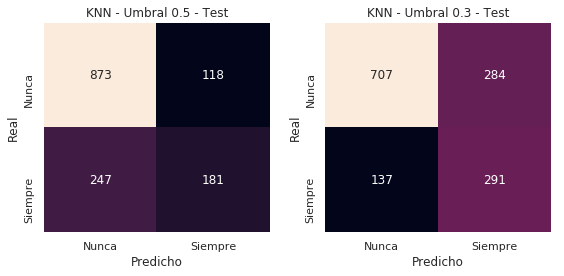

In [72]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_test, y_pred_knn), cbar=False, annot=True, fmt='.0f',ax=axes[0])
sns.heatmap(confusion_matrix(y_test, y_pred_proba_knn_umbral), cbar=False, annot=True, fmt='.0f',ax=axes[1])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('KNN - Umbral 0.5 - Test')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('KNN - Umbral 0.3 - Test')

plt.tight_layout()

Como en Train, aumentan los True Positives (los casos violentos catalogados como tal).

#### KNN - Evaluando resultados (Umbral standard VS Umbral modificado)

In [73]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report

#### KNN - Accuracy - Test
Predicciones positivas (casos catalogados como violentos) sobre total de las predicciones.

In [74]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_knn

0.7427766032417196

In [75]:
accuracy_knn_umbral = accuracy_score(y_test, y_pred_proba_knn_umbral)
accuracy_knn_umbral

0.7033121916842847

#### KNN - Sensitivity o Recall - Test
Entre las respuestas positivas predichas (incluyendo tanto los verdaderos positivos como los falso negativos), ¿cuántas son las verdaderametne positivas?

In [76]:
recall_knn = recall_score(y_test, y_pred_knn)
recall_knn

0.42289719626168226

In [77]:
recall_knn_umbral = recall_score(y_test, y_pred_proba_knn_umbral)
recall_knn_umbral

0.6799065420560748

#### KNN - Specificity - Test
Entre las respuestas negativas predichas (incluyendo tanto los verdaderos negativos como los falso positivos), ¿cuántas son las verdaderametne negativas?

In [78]:
def specificity_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return(specificity)

specificity_knn = specificity_func(y_test, y_pred_knn)
specificity_knn_umbral = specificity_func(y_test, y_pred_proba_knn_umbral)

In [79]:
specificity_knn

0.8809283551967709

In [80]:
specificity_knn_umbral

0.7134207870837538

#### KNN - Curva ROC

In [81]:
# librería
from sklearn.metrics import roc_curve

In [82]:
fpr_knn,tpr_knn,thr_knn = roc_curve(y_test, y_pred_proba_knn[:,1])

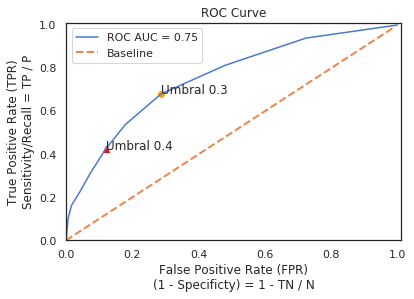

In [83]:
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('False Positive Rate (FPR)\n(1 - Specificty) = 1 - TN / N')
plt.ylabel('True Positive Rate (TPR)\nSensitivity/Recall = TP / P')
plt.title('ROC Curve')

plt.plot(fpr_knn,tpr_knn)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle='--', lw = 2)

plt.scatter(( 1 - specificity_knn_umbral),recall_knn_umbral, marker='o', color='orange')
plt.annotate('Umbral 0.3',(( 1 - specificity_knn_umbral),recall_knn_umbral))

plt.scatter(( 1 - specificity_knn),recall_knn, marker='^', color='red')
plt.annotate('Umbral 0.4',(( 1 - specificity_knn),recall_knn))

plt.legend([f'ROC AUC = {auc(fpr_knn,tpr_knn):.2f}','Baseline'])
plt.show()

### <a id='#reg_log'>2.2 Regresión Logística</a>

In [84]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [85]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=7)
lr.fit(X_train_std, y_train)

y_pred_log_train = lr.predict(X_train_std)

#### Log. Regression - Distribución de resultados y umbral en Train

#### Histograma de probabilidades

In [86]:
nunca = lr.predict_proba(X_train_std[y_train==0])[:,1]
siempre = lr.predict_proba(X_train_std[y_train==1])[:,1]

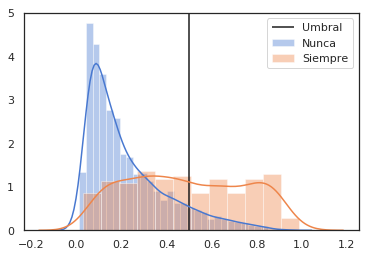

In [87]:
sns.distplot(nunca)
sns.distplot(siempre)
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Nunca', 'Siempre'])
plt.show()

#### Log. Regression - Ajustamos el umbral
El propósito es reducir los casos violentos catalogados por el modelo como no violentos.

In [88]:
umbral = 0.3

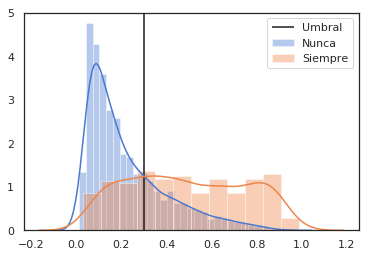

In [89]:
sns.distplot(nunca)
sns.distplot(siempre)
ylim = plt.ylim()
plt.vlines(umbral, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Nunca', 'Siempre'])

In [90]:
print('Respuestas "Siempre" con umbral por defecto:', (lr.predict_proba(X_train_std)[:,1] > 0.5).sum())
print('Respuestas "Siempre" con umbral 0.3:', (lr.predict_proba(X_train_std)[:,1] > 0.3).sum())

Respuestas "Siempre" con umbral por defecto: 868
Respuestas "Siempre" con umbral 0.3: 1685


In [91]:
y_pred_log_umbral = lr.predict_proba(X_train_std)[:,1] > umbral

Evaluamos la matriz con el nuevo umbral

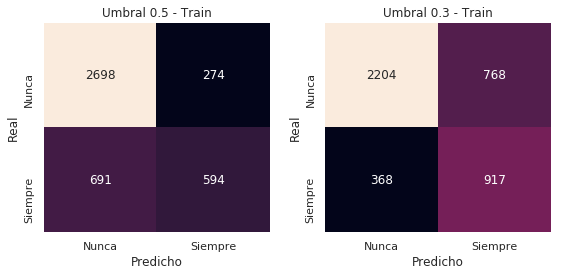

In [92]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_train, y_pred_log_train), cbar=False, annot=True, fmt='.0f',ax=axes[0])
sns.heatmap(confusion_matrix(y_train, y_pred_log_umbral), cbar=False, annot=True, fmt='.0f',ax=axes[1])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('Umbral 0.5 - Train')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('Umbral 0.3 - Train')

plt.tight_layout()

Como se percibe, aumentan las predicciones de respuestas "siempre" para todos los casos, mientras que disminuye la predicción de la respuesta "nunca".

#### Log. Regression - Prediciendo sobre Test
Umbral standard VS Umbral ajustado

In [93]:
from sklearn.metrics import f1_score

y_pred_log = lr.predict(X_test)

y_pred_proba_log = lr.predict_proba(X_test)
# modificamos el umbral para rehacer la predicción sobre test
y_pred_proba_log_umbral = (binarize(y_pred_proba_log, 0.3)[:,1]).astype(int)

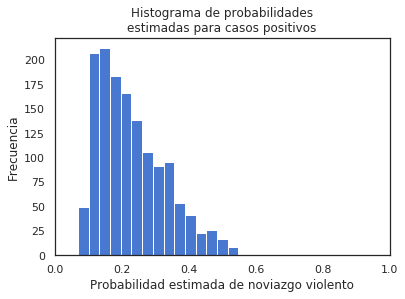

In [94]:
# Histograma de probabilidad para casos positivos ('siempre')

plt.hist(y_pred_proba_log[:,1], bins=15)
plt.xlim(0,1)
plt.title('Histograma de probabilidades\nestimadas para casos positivos')
plt.xlabel('Probabilidad estimada de noviazgo violento')
plt.ylabel('Frecuencia')
plt.show()

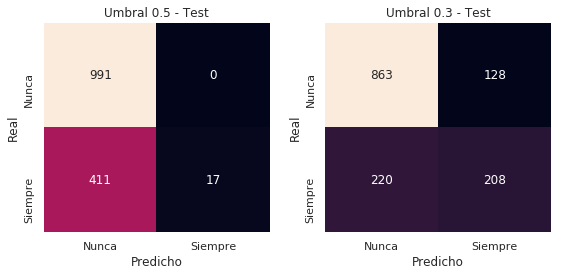

In [95]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_test,y_pred_log), cbar=False, annot=True, fmt='.0f',ax=axes[0])
sns.heatmap(confusion_matrix(y_test,y_pred_proba_log_umbral), cbar=False, annot=True, fmt='.0f',ax=axes[1])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('Umbral 0.5 - Test')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('Umbral 0.3 - Test')

plt.tight_layout()

Como en Train, aumentan los True Positives (los casos violentos catalogados como tal), perdiendo precisión especialmente en la predicción de los casos negativos.

#### Log. Regression - Accuracy - Test
Aumenta la predicción de positivos ('Siempre') sobre todas las predicciones

In [96]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_log_umbral = accuracy_score(y_test, y_pred_proba_log_umbral)

print('Umbral 0.5 =', accuracy_log)
print('Umbral 0.3 =', accuracy_log_umbral)

Umbral 0.5 = 0.7103594080338267
Umbral 0.3 = 0.7547568710359408


#### Log. Regression - specificity - Test
Disminuye la proporción de negativos verdaderos sobre el total de negativos (verdaderos negativos o falsos positivos).

In [97]:
specificity_log = specificity_func(y_test, y_pred_log)
specificity_log_umbral = specificity_func(y_test, y_pred_proba_log_umbral)

print('Umbral 0.5 =', specificity_log)
print('Umbral 0.3 =', specificity_log_umbral)

Umbral 0.5 = 1.0
Umbral 0.3 = 0.8708375378405651


#### Log. Regression -  Sensibility / Recall - Test
Aumentan los verdaderos positivos entre las respuestas positivas predichas (incluyendo tanto los verdaderos positivos como los falso negativos).

In [98]:
recall_log = recall_score(y_test, y_pred_log)
recall_log_umbral = recall_score(y_test, y_pred_proba_log_umbral)

print('Umbral 0.5 =', recall_log)
print('Umbral 0.3 =', recall_log_umbral)

Umbral 0.5 = 0.0397196261682243
Umbral 0.3 = 0.48598130841121495


#### Log. Regression - Curva ROC

In [99]:
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_proba_log[:,1])

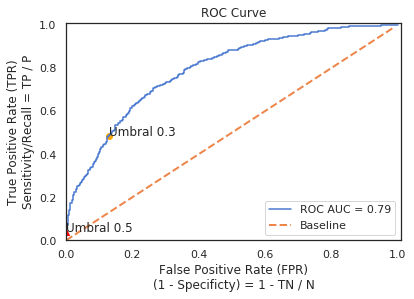

In [100]:
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('False Positive Rate (FPR)\n(1 - Specificty) = 1 - TN / N')
plt.ylabel('True Positive Rate (TPR)\nSensitivity/Recall = TP / P')
plt.title('ROC Curve')

plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle='--', lw = 2)

plt.scatter(( 1 - specificity_log_umbral),recall_log_umbral, marker='o', color='orange')
plt.annotate('Umbral 0.3',(( 1 - specificity_log_umbral),recall_log_umbral))

plt.scatter(( 1 - specificity_log),recall_log, marker='^', color='red')
plt.annotate('Umbral 0.5',(( 1 - specificity_log),recall_log))

plt.legend([f'ROC AUC = {auc(fpr_log,tpr_log):.2f}','Baseline'])
plt.show()

Si bien con un umbral en 0.5 no existen los falsos positivos (casos no violentos clasificados como tal), el sensibility / recall score es muy bajo porque casi no predice casos positivos, al contrario del specifity score, que es muy alto al predecir casi todos los casos como negativos.<br>
Con umbral en 0.3 nos aumentan las predicciones negativas, pero también las positivas, permitiendonos abarcar más casos verdaderamente positivos.

### <a id='naive'>2.3 Naive Bayes Gaussian</a>

In [101]:
from sklearn.naive_bayes import GaussianNB

In [102]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Naive Bayes Gaussian - Performance - Test

In [103]:
y_pred_gnb = gnb.predict(X_test)
# probabilidades con umbral 0.5
y_pred_proba_gnb = gnb.predict_proba(X_test)
# probabilidades con umbral 0.3
y_pred_proba_gnb_umbral = (binarize(y_pred_proba_gnb, 0.3)[:,1]).astype(int)

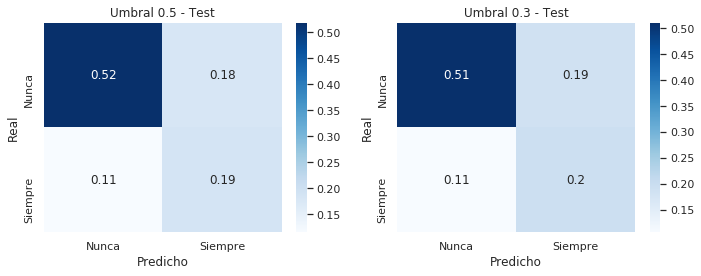

In [104]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex='all')
sns.despine(left=True)

sns.heatmap(confusion_matrix(y_test, y_pred_gnb, normalize = 'all'), annot = True, cmap="Blues",ax=axes[0])
sns.heatmap(confusion_matrix(y_test, y_pred_proba_gnb_umbral, normalize = 'all'), annot = True, cmap="Blues",ax=axes[1])

axes[0].set_xticklabels(['Nunca','Siempre'])
axes[0].set_ylabel('Real')
axes[0].set_yticklabels(['Nunca','Siempre'])
axes[0].set_xlabel('Predicho')
axes[0].set_title('Umbral 0.5 - Test')

axes[1].set_xticklabels(['Nunca','Siempre'])
axes[1].set_ylabel('Real')
axes[1].set_yticklabels(['Nunca','Siempre'])
axes[1].set_xlabel('Predicho')
axes[1].set_title('Umbral 0.3 - Test')

plt.tight_layout()

#### Naive Bayes Gaussian - Accuracy - Test
Aumenta la predicción de positivos ('Siempre') sobre todas las predicciones

In [105]:
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
accuracy_gnb_umbral = accuracy_score(y_test, y_pred_proba_gnb_umbral)

print('Umbral 0.5 =', accuracy_log)
print('Umbral 0.3 =', accuracy_log_umbral)

Umbral 0.5 = 0.7103594080338267
Umbral 0.3 = 0.7547568710359408


#### Naive Bayes Gaussian - Specificity - Test
Disminuye la proporción de negativos verdaderos sobre el total de negativos (verdaderos negativos o falsos positivos).

In [110]:
specificity_gnb = specificity_func(y_test, y_pred_gnb)
specificity_gnb_umbral = specificity_func(y_test, y_pred_proba_gnb_umbral)

print('Umbral 0.5 =', specificity_gnb)
print('Umbral 0.3 =', specificity_gnb_umbral)

Umbral 0.5 = 0.7426841574167508
Umbral 0.3 = 0.7315842583249244


#### Naive Bayes Gaussian - Sensibility / Recall - Test
Aumentan los verdaderos positivos entre las respuestas positivas predichas (incluyendo tanto los verdaderos positivos como los falso negativos).

In [111]:
recall_gnb = recall_score(y_test, y_pred_gnb)
recall_gnb_umbral = recall_score(y_test, y_pred_proba_gnb_umbral)

print('Umbral 0.5 =', recall_gnb)
print('Umbral 0.3 =', recall_gnb_umbral)

Umbral 0.5 = 0.6191588785046729
Umbral 0.3 = 0.647196261682243


#### Naive Bayes Gaussian - ROC Curve

In [112]:
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_proba_gnb[:,1])

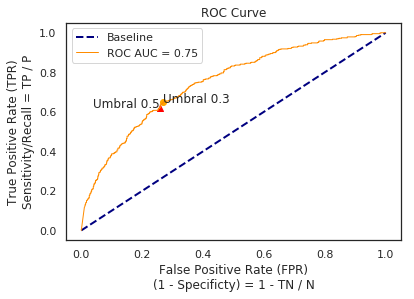

In [113]:
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw = 2)
plt.plot(fpr_gnb, tpr_gnb, color = 'darkorange', lw = 1)

plt.scatter(( 1 - specificity_gnb_umbral),recall_gnb_umbral, marker='o', color='orange')
plt.annotate('Umbral 0.3',(( 1 - specificity_gnb_umbral),recall_gnb_umbral))

plt.scatter(( 1 - specificity_gnb),recall_gnb, marker='^', color='red')
plt.annotate('Umbral 0.5',(( 1 - specificity_gnb),recall_gnb),ha='right')


plt.xlabel('False Positive Rate (FPR)\n(1 - Specificty) = 1 - TN / N')
plt.ylabel('True Positive Rate (TPR)\nSensitivity/Recall = TP / P')
plt.title('ROC Curve')

plt.legend(['Baseline', f'ROC AUC = {auc(fpr_gnb, tpr_gnb):.2f}'])
plt.show()

## <a id='resultados'>2.4 Comparación de Resultados</a>

### ROC Curve - KNN VS Naive Bayes (Gaussian) VS Log. Regression

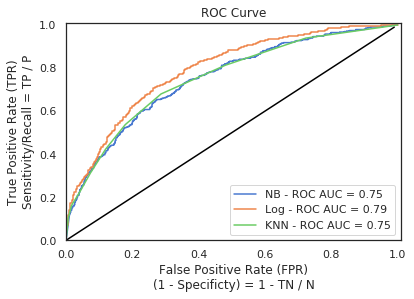

In [115]:
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('False Positive Rate (FPR)\n(1 - Specificty) = 1 - TN / N')
plt.ylabel('True Positive Rate (TPR)\nSensitivity/Recall = TP / P')
plt.title('ROC Curve')

plt.plot(fpr_gnb,tpr_gnb)
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_knn,tpr_knn)

plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color='black')

plt.legend([f'NB - ROC AUC = {auc(fpr_gnb, tpr_gnb):.2f}',f'Log - ROC AUC = {auc(fpr_log, tpr_log):.2f}',f'KNN - ROC AUC = {auc(fpr_knn, tpr_knn):.2f}'])
plt.show() 

### Accuracy / Recall / Specifity - KNN VS Naive Bayes (Gaussian) VS Log. Regression

Text(0.5,1,'Specificty - True Negative Rate (TNR)\n TN / N')

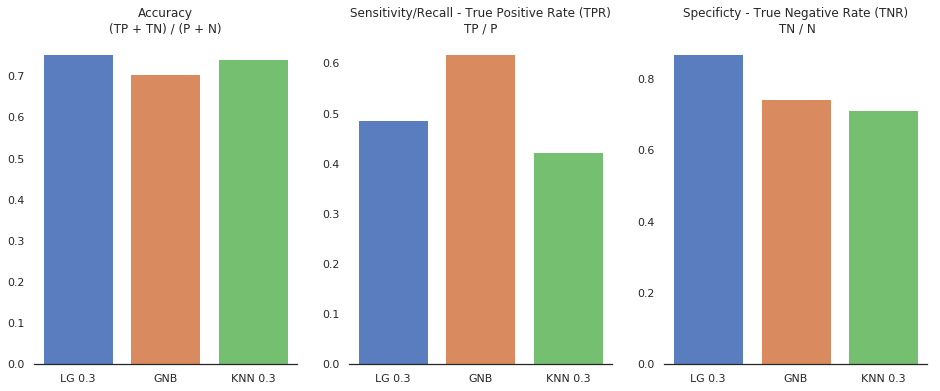

In [116]:
f, axes = plt.subplots(1, 3, figsize=(16, 6), sharex='all')
sns.despine(left=True)

sns.barplot(x=['LG 0.3','GNB','KNN 0.3'],y=[accuracy_log_umbral, accuracy_gnb, accuracy_knn],ax=axes[0])
sns.barplot(x=['LG 0.3','GNB','KNN'],y=[recall_log_umbral, recall_gnb, recall_knn],ax=axes[1])
sns.barplot(x=['LG 0.3','GNB','KNN 0.3'],y=[specificity_log_umbral, specificity_gnb, specificity_knn_umbral],ax=axes[2])


axes[0].set_title('Accuracy\n(TP + TN) / (P + N)')
axes[1].set_title('Sensitivity/Recall - True Positive Rate (TPR)\nTP / P')
axes[2].set_title('Specificty - True Negative Rate (TNR)\n TN / N')



<hr>

## <a id='section_consolidacion'>3. Consolidación</a>

### <a id='pipe'>3.1 Pipelines</a>

In [117]:
X = dataset.drop('pregunta_13', axis = 1)
y = (dataset.pregunta_13 != 'C').astype(int)

In [118]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


Genero un transformador que toma las columnas que quiero y asi reutilizarlo en varios steps

In [119]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features=selected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.selected_features]

Para la edad el pipeline va a crear 4 bins:

* Menor de 25
* De 25 a 49
* De 50 a 74
* De 75 en adelante

In [120]:
edad_pipeline = make_pipeline(ColumnSelector(['edad']), KBinsDiscretizer(4, strategy = 'uniform', encode = 'onehot-dense'))

Para las preguntas, utilizamos OneHotEncoder y utilizamos todas las disponibles en el X

In [121]:
preguntas_col = [col for col in X.columns if "pregunta_" in col]
preguntas_pipeline = make_pipeline(ColumnSelector(preguntas_col), OneHotEncoder(sparse=False, handle_unknown='ignore'))

Para el barrio y el genero, lo transformamos tambien usando OneHotEncoder

In [122]:
barrio_pipeline = make_pipeline(ColumnSelector(['barrio']), OneHotEncoder(sparse=False, handle_unknown='ignore'))

In [123]:
genero_pipeline = make_pipeline(ColumnSelector(['genero']), OneHotEncoder(sparse=False, handle_unknown='ignore'))

Por ultimo, creamos un pipeline con la union de estos pasos anteriores

In [124]:
preprocess_pipeline = make_union(edad_pipeline, preguntas_pipeline, barrio_pipeline, genero_pipeline)

#### Pipelines - Divido en train y test

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=7)

#### Pipelines - Pipeline de entrenamiento y prediccion

Utilizamos la funcionalidad de GridSearch y Pipelines para probar varios modelos en gridsearch.

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

In [127]:
pipeline = Pipeline(steps = [
    ('preprocess', preprocess_pipeline),
    ('estimator', GaussianNB())
])

Utilizamos el placeholder None para utilizar la grilla de hiperparametros mas adelante para insertarle distintos modelos

#### Pipelines - GridSearch 

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [129]:
params_grid =[
    {'estimator':[GaussianNB()]},
    {
        'estimator': [MultinomialNB()],
        'estimator__alpha': np.linspace(0, 2, 20)
    },
    {
        'estimator': [KNeighborsClassifier()],
        'estimator__n_neighbors': range(1, 15),
        'estimator__p': [1, 2]
    },
    {
        'estimator': [LogisticRegression()],
        'estimator__penalty': ['l2', 'l1', 'elasticnet', 'none'],
        'estimator__C': np.linspace(0, 5, 100)
    }
]

In [130]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [131]:
model = GridSearchCV(pipeline, params_grid, cv = folds, n_jobs = -1, scoring='roc_auc', verbose = 1, return_train_score = True)

In [132]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 449 candidates, totalling 2245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2245 out of 2245 | elapsed:  7.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pipeline-1',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('columnselector',
                                                                                         ColumnSelector(selected_features=['edad'])),
                                                                                        ('kbinsdiscretizer',
                                                                                         KBinsDiscretizer(encode='onehot-dense',
                                                                      

In [133]:
model.best_score_ # train

0.7908738542384687

In [134]:
model.best_params_

{'estimator': LogisticRegression(C=0.050505050505050504, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'estimator__C': 0.050505050505050504,
 'estimator__penalty': 'l2'}

In [135]:
model.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('columnselector',
                                                                  ColumnSelector(selected_features=['edad'])),
                                                                 ('kbinsdiscretizer',
                                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                                   n_bins=4,
                                                                                   strategy='uniform'))],
                                                          verbose=False)),
                                                ('pipeline-2',
                                              

#### Pipelines - Verificacion de performance - Test

In [136]:
y_pred_pipe = model.predict(X_test)
y_pred_proba_pipe = model.predict_proba(X_test)

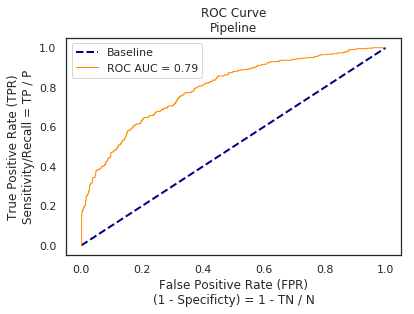

In [137]:
fpr_pipe, tpr_pipe, thresholds_pipe = roc_curve(y_test, y_pred_proba_pipe[:,1])
auc_score = auc(fpr_pipe, tpr_pipe)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw = 2)
plt.plot(fpr_pipe, tpr_pipe, color = 'darkorange', lw = 1)

plt.xlabel('False Positive Rate (FPR)\n(1 - Specificty) = 1 - TN / N')
plt.ylabel('True Positive Rate (TPR)\nSensitivity/Recall = TP / P')
plt.title('ROC Curve\nPipeline')
plt.legend(['Baseline', f'ROC AUC = {auc_score:.2f}'])
plt.show()

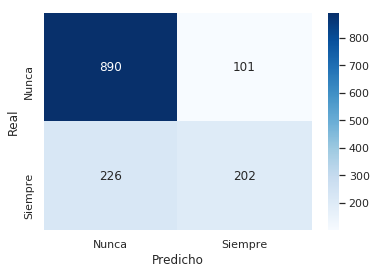

In [138]:
fig = plt.figure(figsize=(6, 4))
axes = plt.axes()

sns.heatmap(confusion_matrix(y_test, y_pred_pipe), annot = True, fmt='.0f',cmap="Blues")

axes.set_xticklabels(['Nunca','Siempre'])
axes.set_ylabel('Real')
axes.set_yticklabels(['Nunca','Siempre'])
axes.set_xlabel('Predicho')
plt.show()

In [141]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_pipe, y_test))

              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1116
           1       0.47      0.67      0.55       303

    accuracy                           0.77      1419
   macro avg       0.69      0.73      0.70      1419
weighted avg       0.81      0.77      0.78      1419



In [154]:
log_loss(y_test, y_pred_proba_pipe)

0.48257128480562134

In [155]:
log_loss(y_train, model.predict_proba(X_train))

0.47963887060436977

## <a id='conclusion'>3.2 Conclusión</a>

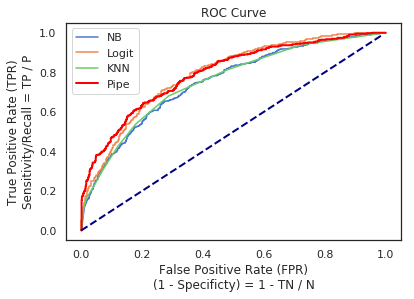

In [156]:
plt.xlabel('False Positive Rate (FPR)\n(1 - Specificty) = 1 - TN / N')
plt.ylabel('True Positive Rate (TPR)\nSensitivity/Recall = TP / P')
plt.title('ROC Curve')

plt.plot(fpr_gnb,tpr_gnb)
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_knn,tpr_knn)
plt.plot(fpr_pipe, tpr_pipe, lw = 2, color='red')

plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color='navy', linestyle='--', lw = 2)

plt.legend(['NB','Logit','KNN','Pipe'])
plt.show() 

In [157]:
accuracy_pipe = accuracy_score(y_test, y_pred_pipe)
accuracy_pipe

0.7695560253699789

In [158]:
specificity_pipe = specificity_func(y_test, y_pred_pipe)
specificity_pipe

0.8980827447023209

In [159]:
recall_pipe = recall_score(y_test, y_pred_pipe)
recall_pipe

0.4719626168224299

Text(0.5,1,'Specificty - True Negative Rate (TNR)\n TN / N')

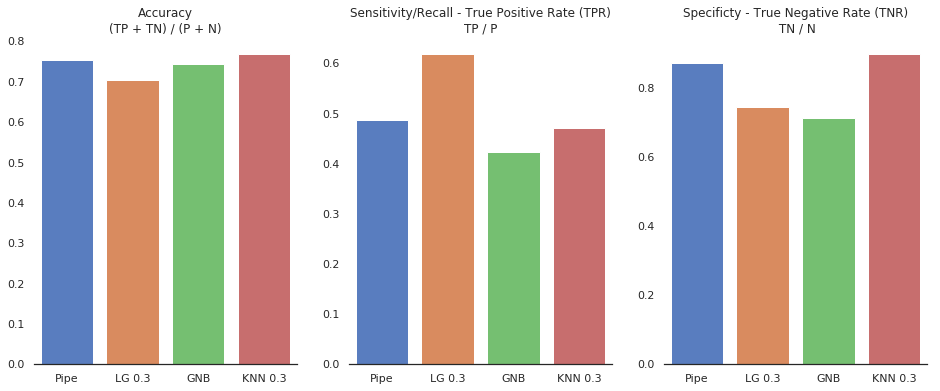

In [160]:
f, axes = plt.subplots(1, 3, figsize=(16, 6), sharex='all')
sns.despine(left=True)

sns.barplot(x=['Pipe','LG 0.3','GNB','KNN 0.3'],y=[accuracy_log_umbral, accuracy_gnb, accuracy_knn,accuracy_pipe],ax=axes[0])
sns.barplot(x=['Pipe','LG 0.3','GNB','KNN'],y=[recall_log_umbral, recall_gnb, recall_knn,recall_pipe],ax=axes[1])
sns.barplot(x=['Pipe','LG 0.3','GNB','KNN 0.3'],y=[specificity_log_umbral, specificity_gnb, specificity_knn_umbral,specificity_pipe],ax=axes[2])

axes[0].set_title('Accuracy\n(TP + TN) / (P + N)')
axes[1].set_title('Sensitivity/Recall - True Positive Rate (TPR)\nTP / P')
axes[2].set_title('Specificty - True Negative Rate (TNR)\n TN / N')